This is data from Jena,Germany where 14 features like wind pressure,air temperatue were recorded for every 10 minutes for 7 years.

In [ ]:
csv_dir = "/Users/dynam/Desktop/Deep learning files"
fname = csv_dir + "/jena_climate_2009_2016.csv"
f = open(fname,"r")
data = f.read()
f.close()
lines = data.split("\n")
headings = lines[0].split(",")
lines = lines[1:]
print(headings)
print(len(lines))

FileNotFoundError: ignored

In [ ]:
import pandas as pd
df = pd.read_csv(fname)
print(df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
rows = len(lines)
columns = len(headings) - 1 #except data time heading
float_data = np.zeros((rows,columns))
for i,line in enumerate(lines): #each line has a counter representent a row
    #print(line.split(",")[1:])
    if(i<=200000):
        float_data[i:] = [float(x) for x in line.split(",")[1:]] #convert every value in a row except the data time into float
        print(i)

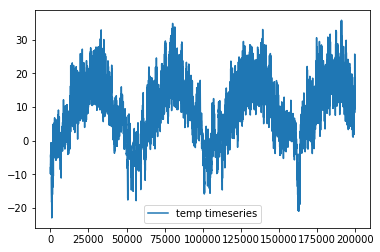

In [ ]:
#plotting temperature timeseries
temp = float_data[:200000,1] #200000 rows for temp column
x = [i for i in range(1,len(temp)+1)]
y = []
for i in range(200000):
    y.append(float_data[i,1])
plt.plot(x,y,label = "temp timeseries")
plt.legend()
plt.show()

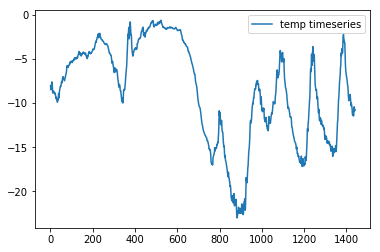

In [ ]:
#plotting 10 days temperature or 10*24*6 timesteps of data as one timestep is 10min
#plotting temperature timeseries
x = [i+1 for i in range(10*24*6)]
y = []
for i in range(10*24*6):
    y.append(float_data[i,1])
plt.plot(x,y,label = "temp timeseries")
plt.legend()
plt.show()

In [ ]:
#normalizing the data
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std
float_data.shape

(420551, 14)

In [ ]:
#generator
'''def generator(data,lookback,delay,min_index,max_index,shuffle = False,batch_size = 128,steps = 6):
    if max_index == None:
        max_index = (len(data) - 1) - delay
    i = min_index + lookback
    while True:
        if shuffle == True:
            rows = np.random.randint(min_index,max_index,size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            #creating rows array
            rows = np.arange(i,max(i+batch_size,max_index))
            i = i + len(rows)
        samples = np.zeros((len(rows),lookback//step,data.shape[-1]))#batch_size,10 days worth of datapoints//steps = datapoint recorded every hour once for 10 days ie 240,14 features per data point 
        #print(samples.ndim)
        #creating targets numpy array
        targets = np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],steps)#gives one data point per hour for 10 days
            #print(data[indices])
            samples[j] = data[indices]#training_data for the model is the temp for the past 10 days of floa_data
            targets[j] = data[rows[j]+delay][1] #gives the target_data/temperature on (rows[j]+delay)number of days in the float_data
            #ex:we show the model how the temperature is for the first 10 days and how the temperature will be after "delay" number of days.This way we train the model for predicting the temperature on "delay" days given the temperature on "lookback" days.
        yield samples,targets
    print("end of while loop")'''
def generator(data, lookback, delay, min_index, max_index,
    shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
        lookback // step,
        data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
#genrating train_data set using generator
#each generator will look at different temporal segments of original data
lookback = 6*24*10 #10 days of prev data
step = 6
delay = 6*24
batch_size = 128

train_gen = generator(data = float_data,lookback = lookback,delay = delay,min_index = 0,max_index = 200000,shuffle = True,batch_size = batch_size)
val_gen = generator(data = float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,batch_size=batch_size)
test_gen = generator(data = float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [ ]:
#mean absolute error of temperature
def naive_mae():
    print("started")
    batch_mae = []
    for step in range(val_steps):
        samples,targets = next(val_gen)
        #print(targets)
        prediction = samples[:,-1,1]
        #print(samples[:,-1,1])#10th day temp
        mae = np.mean(np.abs(prediction - targets))
        batch_mae.append(mae)
        print(prediction,"------------------------------------",targets)
        #print("test")
    print(np.mean(batch_mae))
naive_mae()


In [ ]:
#mae in celsius
mae_celsius = mae*std[1]

In [ ]:
#first try with densely connected nn
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten())
model.Dense(32,activation = "relu")
model.model(Dense(1))

model.compile(optimizer = RMSprop(),loss = "mae")
history = model.fit_generator(train_gen,steps_per_epoch = 500,epochs = 20,validation_data = val_gen,validation_steps = val_steps)
model.save("weather using Dense.h5")

In [ ]:
#plotting the results
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from kers.layers impor GRU,Dense
from keras.models import Sequential
from kras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32,input_shape = (None,float_data[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),loss = "mae")
history = model.fit_generator(train_gen,steps_per_epoch = 500,epochs = 20,validation_data = val_gen,validation_steps = val_steps)

In [ ]:
#dropout regularized model
from keras.models import Sequential
from keras.import layers
from keras.optimizers RMSprop

model = Sequential()
model.add(GRU(32,dropout = 0.2,recurrent_dropout = 0.2,input_shape = (None,float_data[-1])))
model.add(Dense(1))

model.Compile(optimizer = RMSprop(),loss = "mae")
history = model.fit_generator(train_gen,stepsper_epoch = 500,epochs = 40,validation_data = val_data,validation_steps = val_steps)


In [ ]:
#stacked GRU model
from keras.models import Sequential
from keras.import layers
from keras.optimizers RMSprop

model = Sequential()
model.add(GRU(32,return_sequences = True,dropout = 0.1,recurren_dropout = 0.5,input_shape = (None,float_data[-1])))
model.add(GRU(64,activation = "relu",return_sequences = True,dropout = 0.1,recurren_dropout = 0.5))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),loss = "mae")
history = model.fit_generator(train_gen,steps_per_epoch = 500,epochs = 40,validation_data = val_gen,validation_steps = val_steps)


In [ ]:
#using bidirection GRUs
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32,input_shape = (None,float_data.shape[-1]))))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)


Using TensorFlow backend.


NameError: ignored

In [ ]:
#using 1D conv nets to demonstrate weak memory of conv nets alone
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32,5,input_shape = (None,float_data[-1]),actvation = "relu"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,actvation = "relu"))
model.add(layers.MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

In [ ]:
#combining 1D conv nets and RNN 
#we can either look at more data from the past(increase lookback)
#or we can increase the number of data point used per hour(reduce step)=>we will choose this
step = 3
lookback = 24*3*10
delay = 24*3*2

train_gen = generator(float_data,delay = delay,lookback = lookback,min_index = 0,max_index = 200000,step = step,shuffle = True)
val_gen = generator(float_data,delay = delay,lookback = lookback,min_index = 200001,max_index = 300000,step = step,shuffle = True)
test_gen = generator(float_data,delay = delay,lookback = lookback,min_index = 300000,max_index = None,step = step,shuffle = True)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128


In [ ]:
#model combining 1D conv base and GRU layer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32,5,activation = "relu",input_shape = (None,float_data[-1])))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32,5,actvation = "relu"))
model.add(layers.GRU(32,dropout = 0.5,recurrent_dropout = 0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)